In [2]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="qwen-2.5-32b")

In [3]:
# llm.invoke("hi")

In [4]:
# from langchain_google_genai import GoogleGenerativeAIEmbeddings
# embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

# from langchain_google_genai import ChatGoogleGenerativeAI
# llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [5]:
from langchain.tools.tavily_search import TavilySearchResults
from langchain.prompts import PromptTemplate
# from langchain_community.tools import text
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain.tools.retriever import create_retriever_tool

from langchain_community.vectorstores import Chroma



USER_AGENT environment variable not set, consider setting it to identify your requests.


In [6]:


from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

/home/dev/Desktop/Learning/AI/graph_yt/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def search_web(query: str):
    search = TavilySearchResults()
    results = search.invoke(query)
    return results[:3]
   

In [8]:
urls=search_web("what is the price of the reliance")

In [9]:
urls

[{'title': 'RELIANCE Share Price — NSE:RELIANCE - TradingView',
  'url': 'https://www.tradingview.com/symbols/NSE-RELIANCE/',
  'content': 'The current price of RELIANCE is 1,185.35 INR — it has increased by 0.27% in the past 24 hours. Watch RELIANCE INDUSTRIES LTD stock price performance more',
  'score': 0.8846886},
 {'title': 'Reliance Industries Ltd. (RIL)Stock , RLNIY - Markets Insider',
  'url': 'https://markets.businessinsider.com/stocks/rlniy-stock',
  'content': 'The latest Reliance Industries stock prices, stock quotes, news, and RLNIY ... 56.40, 56.50, 56.00, 115,668.00. Price change over selected period: -4.26%-2.4',
  'score': 0.798077},
 {'title': 'RIL Share Price - Stocks - The Economic Times',
  'url': 'https://economictimes.indiatimes.com/reliance-industries-ltd/stocks/companyid-13215.cms',
  'content': 'Stock gave a 3 year return of 7.53% as compared to Nifty 100 which gave a return of 37.78%. (as of last trading session)\nSell Signal: Bearish trend in offing\n5 day m

In [10]:
# urls[0:]["url"]

In [11]:
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage, HumanMessage
from typing import Annotated, Literal, Sequence, TypedDict
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate

In [12]:
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage],add_messages]

### Retriver And Handle tool

In [13]:
def get_retriver(urls: list[str]):
    """
    Fetch results from the web using a list of URLs and store them in a vector store.
    """
    if not urls:
        raise ValueError("URL list is empty.")

    docs_main=[item["url"] for item in urls]
    docs = [WebBaseLoader(url).load() for url in docs_main]
    print("----docs----", docs)

    docs_list = [item for sublist in docs for item in sublist]

    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=100,
        chunk_overlap=50,
    )
    doc_splits = text_splitter.split_documents(docs_list)

   
    return doc_splits


In [14]:
vectorstore = Chroma.from_documents(
        documents=get_retriver(urls),
        collection_name="stock_chroma",
        persist_directory="./stock_data",
        embedding=embeddings,
    )

----docs---- [[Document(metadata={'source': 'https://www.tradingview.com/symbols/NSE-RELIANCE/', 'title': 'RELIANCE Share Price — NSE:RELIANCE — TradingView', 'description': "View live RELIANCE INDUSTRIES LTD chart to track its stock's price action. Find market predictions, RELIANCE financials and market news.", 'language': 'en'}, page_content="\n\n\n\n RELIANCE Share Price — NSE:RELIANCE — TradingView\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\n \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n  \n\n\n\n\n\n\n \n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\

In [15]:
retriever=vectorstore.as_retriever()
retreiver_tool=create_retriever_tool(
    retriever=retriever,
    name="stock_retriever",
    description="use this tool to get the stock information",
    # return_only_outputs=True,
)


In [16]:
tools=[retreiver_tool,search_web,get_retriver]
llm_with_tools=llm.bind_tools(tools)
# result = test.get_relevant_documents("What is the revenue of the company?")
# print("----result----", result)

In [17]:
def checker_type(tool):
    return "retrieve" in tool.name.lower() or "retriever" in tool.description.lower()


In [18]:
res=checker_type(tools[0])
print("----res----", res)

----res---- True


In [19]:
def all_reviewer(state: AgentState) -> str:
    messages = state["messages"]
    last_message = messages[-1]["content"]
    tools = state.get("tools", [])

    # Separate retriever tools and others for clarity
    retriever_tools = [tool for tool in tools if checker_type(tool)]
    other_tools = [tool for tool in tools if not checker_type(tool)]
    print("----retriever_tools----", retriever_tools)
    print("----other_tools----", other_tools)

    # Prepare a friendly and smart prompt
    tool_names = ", ".join([tool.name for tool in tools])
    prompt = PromptTemplate(
        input_variables=["input", "tools"],
        template="""You are a helpful and intelligent assistant with access to the following tools: {tools}.
        Carefully consider the question below using all available tools. Make sure you check:
        - All relevant retriever tools for background info or data.
        - Use any other appropriate tools if needed.

        Then, respond in a clear, friendly, and polite manner, summarizing everything nicely at the end.

        Question:
        {input}
        """)

    formatted_prompt = prompt.format(input=last_message, tools=tool_names)

    # Return or pass this prompt to the LLM
    return formatted_prompt

In [20]:
all_reviewer({"messages": [{"role": "user", "content": "What is the revenue of the company?"}]})

----retriever_tools---- []
----other_tools---- []


'You are a helpful and intelligent assistant with access to the following tools: .\n        Carefully consider the question below using all available tools. Make sure you check:\n        - All relevant retriever tools for background info or data.\n        - Use any other appropriate tools if needed.\n\n        Then, respond in a clear, friendly, and polite manner, summarizing everything nicely at the end.\n\n        Question:\n        What is the revenue of the company?\n        '

In [21]:
from langchain import hub 
from langchain_core.output_parsers import StrOutputParser

prompt= hub.pull("rlm/rag-prompt")


In [22]:
rag_chain= prompt | llm


In [23]:
def get_relevant_documents(query: str):
    """
    Fetch relevant documents from the vector store using the retriever.
    """
    if not query:
        raise ValueError("Query is empty.")

    docs = retriever.get_relevant_documents(query)
    return docs

In [24]:
### Answer 
def answer_grader(state: AgentState,docs) -> str:
    # Data model
    messages= state["messages"]
    question = messages[-1]

    rag_chain= prompt | llm
    generation=rag_chain.invoke({"question": question, "context":docs})
    class GradeAnswer(BaseModel):
        """Binary score to assess answer addresses question."""

        binary_score: str = Field(
            description="Answer addresses the question, 'yes' or 'no'"
        )


    # LLM with function call
    structured_llm_grader = llm.with_structured_output(GradeAnswer)

    # Prompt
    system = """You are a grader assessing whether an answer addresses / resolves a question \n 
        Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
    answer_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
        ]
    )

    answer_grader = answer_prompt | structured_llm_grader
    print(answer_grader.invoke({"question": question, "generation": generation}))

In [25]:
def ai_assistant(state:AgentState):
    print("----State----",state['messages'])
    print("---CALL AGENT---")
    messages = state['messages']
    
    if len(messages)>1:
        last_message = messages[-1]
        question = last_message.content
        prompt=PromptTemplate(
        template="""You are a helpful assistant whatever question has been asked to find out that in the given question and answer.
                        Here is the question:{question}
                        """,
                        input_variables=["question"]
                        )
            
        chain = prompt | llm
    
        response=chain.invoke({"question": question})
        return {"messages": [response]}
    else:
        llm_with_tool = llm.bind_tools(tools)
        response = llm_with_tool.invoke(messages)
        #response=handle_query(messages)
        return {"messages": [response]}

In [26]:
def final_answer(state):
    # Get the last message from the state
    last_message = state["messages"][-1]["content"]
    
    # Use the LLM to generate a response
    response = llm.invoke(last_message)
    
    # Return the generated response
    return response

In [27]:
from langgraph.graph import StateGraph,START,END

In [28]:
# workflow = StateGraph(AgentState)

# workflow.add_node("ai_assistant", ai_assistant)
# workflow.add_node("web_scraper", search_web)
# workflow.add_node("get_relevant_documents", get_relevant_documents)
# workflow.add_node("all_reviewer", all_reviewer)
# workflow.add_node("save_retriever", get_retriver)
# workflow.add_node("final_answer",final_answer)
    

In [45]:
from langgraph.graph import StateGraph
from langgraph.graph import START, END

# Define your StateGraph with a base state
workflow = StateGraph(AgentState)

# --- Add Nodes ---
workflow.add_node("ai_assistant", ai_assistant)
workflow.add_node("web_scraper", search_web)
workflow.add_node("get_relevant_documents", get_relevant_documents)
# workflow.add_node("all_reviewer", all_reviewer)
workflow.add_node("save_retriever", get_retriver)
workflow.add_node("final_answer", final_answer)

# --- Add Edges ---

# Start the graph
workflow.add_edge(START, "ai_assistant")

# Go from AI assistant to document retrieval
workflow.add_edge("ai_assistant", "get_relevant_documents")

# Conditional branching after document retrieval
workflow.add_conditional_edges(
    "get_relevant_documents",
    answer_grader,  # This is the branching function
    {
        "useful": "final_answer",
        "not_useful": "web_scraper",
    }
)

# Conditional branching after web scraping
workflow.add_conditional_edges(
    "web_scraper",
    all_reviewer,  # This is the branching function
    {
        "save": "save_retriever",
        "not_save": "final_answer",
    }
)

# Continue to final answer

workflow.add_edge("save_retriever", "final_answer")

# End the graph
workflow.add_edge("final_answer", END)

# Optional: Set finish point explicitly
# workflow.set_finish_point("final_answer")


In [46]:
app=workflow.compile()

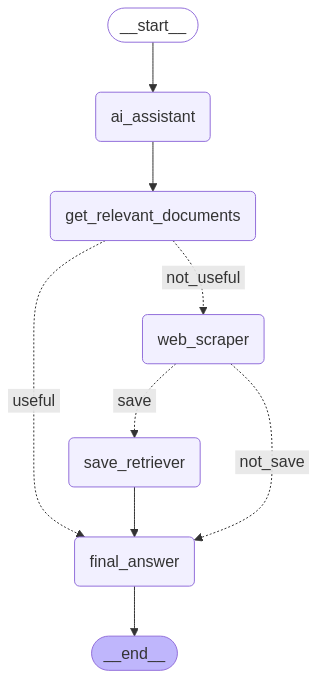

In [47]:
app